In [1]:
import pandas as pd
import numpy as np
from data.get_data import FetchPlansPricings
from data.clean_data import HMOEPOCleaner, PPOPOSCleaner
from features.feature_building import FeatureEngineer
from models.v1_model import MedicalPlanSimilarityModel
from sklearn.neighbors import NearestNeighbors
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

### Fetch Data

In [4]:
data_fetcher = FetchPlansPricings(state="CA", zip_code=95030, year=2023, quarter="Q1")
data_fetcher.fetch_and_save_data()
raw_plans_df = pd.read_csv("~/like-plans/data/raw/raw_plans.csv")

/Users/kieranshaw/like-plans/.conda/lib/python3.10/site-packages/google/cloud/bigquery/_pandas_helpers.py:189: UserWarning: Unable to determine type for field '_airbyte_meta'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))


Saved dataframe from CA, 95030, 2023, Q1 to /Users/kieranshaw/like-plans/data/raw/raw_plans.csv
Saved dataframe from CA, 95030, 2023, Q1 to /Users/kieranshaw/like-plans/data/raw/raw_pricings.csv


### Clean Data

In [2]:
# Create an instance of HMOEPOCleaner
hmo_epo_cleaner = HMOEPOCleaner()
ppo_pos_cleaner = PPOPOSCleaner()

# Read the raw data
hmo_epo_raw_data = hmo_epo_cleaner.read_data()
ppo_pos_raw_data = ppo_pos_cleaner.read_data()

# Clean the data
hmo_epo_cleaned_data = hmo_epo_cleaner.clean(df=hmo_epo_raw_data)
ppo_pos_cleaned_data = ppo_pos_cleaner.clean(df=ppo_pos_raw_data)

# Save the cleaned data
hmo_epo_cleaner.save_data(df=hmo_epo_cleaned_data)
ppo_pos_cleaner.save_data(df=ppo_pos_cleaned_data)

### Feature Building

In [2]:
hmo_epo_cleaned_df = pd.read_csv("~/like-plans/data/processed/hmo_epo_plans_cleaned.csv")
ppo_pos_cleaned_df = pd.read_csv("~/like-plans/data/processed/ppo_pos_plans_cleaned.csv")

In [3]:
fe = FeatureEngineer(df=ppo_pos_cleaned_df, exclude_cols=["carrier_name","name","id"])
transformed_array = fe.fit_transform()

In [4]:
model = MedicalPlanSimilarityModel(ppo_pos_cleaned_df, transformed_array, metric='cosine', n_neighbors=10)
random_plan, similar_plans = model.fit()

In [5]:
random_plan

,id,carrier_name,name,level,plan_type,hsa_eligible,infertility_treatment_rider,individual_medical_deductible_in_network,individual_medical_deductible_out_of_network,family_medical_deductible_in_network,family_medical_deductible_out_of_network,individual_medical_moop_in_network,individual_medical_moop_out_of_network,family_medical_moop_in_network,family_medical_moop_out_of_network,coinsurance_in_network,coinsurance_out_of_network
334,70285CA8160382,BlueShield of California,Silver Tandem PPO Savings 2300/25% OffEx,silver,PPO,1,0,2300,4600,3000,6000,7500,15000,15000,30000,25,50


In [6]:
similar_plans

,id,carrier_name,name,level,plan_type,hsa_eligible,infertility_treatment_rider,individual_medical_deductible_in_network,individual_medical_deductible_out_of_network,family_medical_deductible_in_network,family_medical_deductible_out_of_network,individual_medical_moop_in_network,individual_medical_moop_out_of_network,family_medical_moop_in_network,family_medical_moop_out_of_network,coinsurance_in_network,coinsurance_out_of_network,similarity_score
334,70285CA8160382,BlueShield of California,Silver Tandem PPO Savings 2300/25% OffEx,silver,PPO,1,0,2300,4600,3000,6000,7500,15000,15000,30000,25,50,0.000000
25,27603CA1220575,Anthem,Anthem Silver Select PPO 2100/30% w/HSA PrevRx,silver,PPO,1,0,2100,4200,4200,8400,7200,14400,14400,28800,30,50,0.021949
24,27603CA1220560,Anthem,Anthem Silver PPO 2100/30% w/HSA PrevRx,silver,PPO,1,0,2100,4200,4200,8400,7200,14400,14400,28800,30,50,0.021949
343,70285CA8160517,BlueShield of California,Silver Tandem PPO Savings 2600/35% HDHP PrevRx...,silver,PPO,1,0,2600,5200,3000,6000,7500,15000,15000,30000,35,50,0.032313
337,70285CA8160433,BlueShield of California,Silver Full PPO Savings 2600/35% HDHP PrevRx O...,silver,PPO,1,0,2600,5200,3000,6000,7500,15000,15000,30000,35,50,0.032313
6,27603CA0000003-77,CalChoice,Anthem Select PPO Silver PPO E,silver,PPO,1,0,2000,4000,4000,8000,7050,14100,14100,28200,35,50,0.050560
5,27603CA0000002-77,CalChoice,Anthem Prudent Buyer Silver PPO D (OOA),silver,PPO,1,0,2000,4000,4000,8000,7050,14100,14100,28200,35,50,0.050560
70,27603CA1221561,Anthem,Anthem Silver Select PPO 2600/35% w/HSA PrevRx,silver,PPO,1,0,2600,5200,5200,10400,7050,14100,14100,28200,35,50,0.070197
68,27603CA1221547,Anthem,Anthem Silver PPO 2600/35% w/HSA PrevRx,silver,PPO,1,0,2600,5200,5200,10400,7050,14100,14100,28200,35,50,0.070197
74,37873CA0090001-13,UnitedHealthcare,Select Plus PPO HDHP Silver CVQQ /L46S,silver,PPO,1,0,2800,5600,3000,6000,7500,14700,15000,29400,40,50,0.071244


In [5]:
# Assuming `transformed_array` is the array you used to fit the NearestNeighbors model
specific_plan_features = transformed_array[random_plan_index].reshape(1, -1)

# Find the nearest neighbors
distances, indices = model.kneighbors(specific_plan_features)


In [6]:
similar_plans_indices = indices.flatten()[1:]  # Exclude the first index (the plan itself)
similar_plans_df = ppo_pos_cleaned_df.iloc[similar_plans_indices]

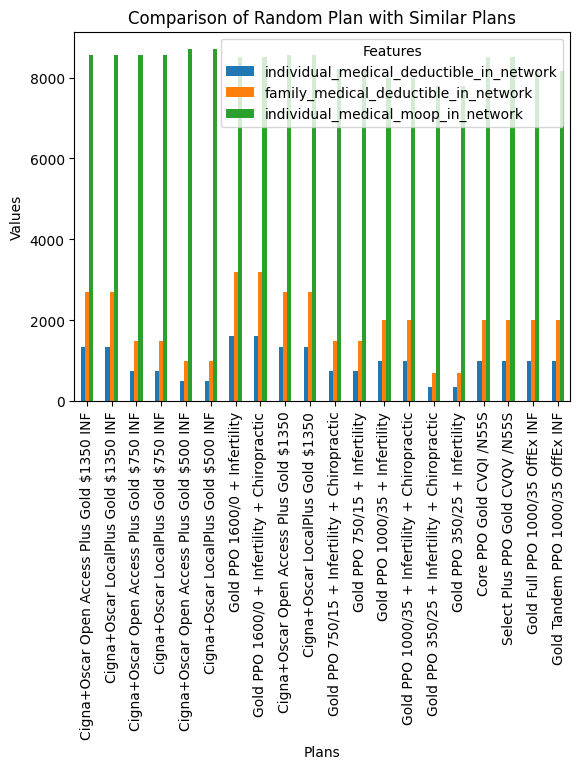

In [7]:
import matplotlib.pyplot as plt
comparison_df = pd.concat([random_plan_df, similar_plans_df])

features_to_compare = ['individual_medical_deductible_in_network', 'family_medical_deductible_in_network', 'individual_medical_moop_in_network']  # Replace with actual features

plan_names = [random_plan_df['name'].iloc[0]] + similar_plans_df['name'].tolist()

comparison_df[features_to_compare].plot(kind='bar')
plt.title('Comparison of Random Plan with Similar Plans')
plt.xlabel('Plans')
plt.ylabel('Values')
plt.xticks(ticks=np.arange(len(comparison_df)), labels=plan_names)
plt.legend(title='Features')
plt.show()

In [26]:
comparison_df.columns

Index(['id', 'carrier_name', 'name', 'level', 'plan_type', 'hsa_eligible',
       'infertility_treatment_rider',
       'individual_medical_deductible_in_network',
       'individual_medical_deductible_out_of_network',
       'family_medical_deductible_in_network',
       'family_medical_deductible_out_of_network',
       'individual_medical_moop_in_network',
       'individual_medical_moop_out_of_network',
       'family_medical_moop_in_network', 'family_medical_moop_out_of_network',
       'coinsurance_in_network', 'coinsurance_out_of_network'],
      dtype='object')

In [18]:
import matplotlib.pyplot as plt

# Select the features to compare
features_to_compare = ['cost', 'coverage', 'rating']  # Replace with your actual feature names

# Create a DataFrame for plotting
plot_df = pd.concat([random_plan[features_to_compare], similar_plans[features_to_compare]])

# Reset index for better plotting
plot_df.reset_index(drop=True, inplace=True)

# Create the bar chart
plot_df.plot(kind='bar')
plt.title('Comparison of Selected Features')
plt.xlabel('Plans')
plt.ylabel('Feature Values')
plt.xticks(ticks=range(len(plot_df)), labels=['Random Plan'] + ['Similar Plan ' + str(i) for i in range(1, len(similar_plans) + 1)])
plt.legend(title='Features')
plt.show()


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

### Model Testing

In [44]:
hmo_epo_feat_df = pd.read_csv("~/like-plans/data/processed/hmo_epo_plans_features.csv")
ppo_pos_feat_df = pd.read_csv("~/like-plans/data/processed/ppo_pos_plans_features.csv")

In [61]:
# Initialize and fit the cosine similarity model
model = NearestNeighbors(metric='manhattan')
model.fit(ppo_pos_feat_df.drop(['id', 'carrier_name', 'name'], axis=1))

NearestNeighbors(metric='manhattan')

In [62]:
def find_similar_for_each_carrier(df, cosine_sim_matrix):
    similar_plans = []

    for carrier in df['carrier_name'].unique():
        # Filter plans for the current carrier
        carrier_plans = df[df['carrier_name'] == carrier]

        # Select a random plan
        random_plan = carrier_plans.sample(1)
        random_plan_index = random_plan.index[0]

        # Get cosine similarity scores for the random plan
        similarities = cosine_sim_matrix[random_plan_index]

        # Exclude the plan itself from the comparison
        similarities[random_plan_index] = -1

        # Find the index of the plan with the highest similarity
        similar_plan_index = np.argmax(similarities)

        # Retrieve the ID of the similar plan
        similar_plan_id = df.iloc[similar_plan_index]['id']
        similar_plans.append((random_plan['id'].values[0], similar_plan_id))

    return similar_plans

# Assuming you have a DataFrame `transformed_df` and a cosine similarity matrix `cosine_similarity_matrix`
similar_plans = find_similar_for_each_carrier(transformed_df, cosine_similarity_matrix)
print(similar_plans)


[('27330CA0130006', '70285CA8160306'), ('27603CA0000013-77', '27603CA0000015-77'), ('27603CA1220896', '27603CA1220837'), ('49116CA0100013-13', '49116CA0100017-13'), ('40025CA0080052', '40025CA0080180'), ('40733CA0090090', '40733CA0090089'), ('67138CA0730178', '67138CA0730178-33'), ('70285CA8150007', '27603CA1221135'), ('70285CA8160075', '70285CA8160669')]


In [63]:
raw_plans_df = pd.read_csv("~/like-plans/data/raw/raw_plans.csv")


def display_similar_plans_for_each_carrier(df, cosine_sim_matrix, raw_plans_df):
    results_data = []
    unique_carriers = df['carrier_name'].unique()

    # Select one random plan from the entire dataset
    random_plan = df.sample(1)
    random_plan_id = random_plan['id'].values[0]
    random_plan_index = random_plan.index[0]

    for carrier in unique_carriers:
        # Filter plans for the current carrier
        carrier_plans = df[df['carrier_name'] == carrier]

        # Get cosine similarity scores for the random plan
        similarities = cosine_sim_matrix[random_plan_index]

        # Find the most similar plan within the carrier
        carrier_plan_indices = carrier_plans.index
        carrier_similarities = similarities[carrier_plan_indices]

        # Exclude the random plan itself if it's in the same carrier
        if random_plan_index in carrier_plan_indices:
            carrier_similarities = np.where(carrier_plan_indices == random_plan_index, -1, carrier_similarities)

        # Find the index of the plan with the highest similarity
        if len(carrier_similarities) > 0:
            similar_plan_index = carrier_plan_indices[np.argmax(carrier_similarities)]
            similar_plan_id = df.loc[similar_plan_index, 'id']

            # Retrieve plan details
            plan_row = raw_plans_df[raw_plans_df['id'] == random_plan_id]
            similar_plan_row = raw_plans_df[raw_plans_df['id'] == similar_plan_id]

            # Append each detail to the results_data list
            results_data.append({
                "Random Plan ID": random_plan_id,
                "Random Plan Name": plan_row['name'].values[0],
                "Random Plan Carrier": plan_row['carrier_name'].values[0],
                "Random Plan Level": plan_row['level'].values[0],
                "Random Plan Deductible": plan_row['individual_medical_deductible'].values[0],
                "Random Plan Coinsurance": plan_row['plan_coinsurance'].values[0],
                "Similar Plan ID": similar_plan_id,
                "Similar Plan Name": similar_plan_row['name'].values[0],
                "Similar Plan Carrier": similar_plan_row['carrier_name'].values[0],
                "Similar Plan Level": similar_plan_row['level'].values[0],
                "Similar Plan Deductible": similar_plan_row['individual_medical_deductible'].values[0],
                "Similar Plan Coinsurance": similar_plan_row['plan_coinsurance'].values[0]
            })

    columns = [
        "Random Plan ID", "Random Plan Name", "Random Plan Carrier", "Random Plan Deductible", "Random Plan Coinsurance", "Random Plan Level",
        "Similar Plan ID", "Similar Plan Name", "Similar Plan Carrier", "Similar Plan Deductible", "Similar Plan Coinsurance", "Similar Plan Level"
    ]

    return pd.DataFrame(results_data, columns=columns)

# Usage
resulting_table = display_similar_plans_for_each_carrier(transformed_df, cosine_similarity_matrix, raw_plans_df)
resulting_table

,Random Plan ID,Random Plan Name,Random Plan Carrier,Random Plan Deductible,Random Plan Coinsurance,Random Plan Level,Similar Plan ID,Similar Plan Name,Similar Plan Carrier,Similar Plan Deductible,Similar Plan Coinsurance,Similar Plan Level
0,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,27330CA0130006,Platinum 90 PPO 0/15 + Child Dental,Kaiser Permanente,In-Network: $0 / Out-of-Network: $500,In-Network: 10% / Out-of-Network: 30%,platinum
1,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,27603CA0000016-77,Anthem Select PPO Gold PPO C,CalChoice,"In-Network: $500 / Out-of-Network: $2,000",In-Network: 20% / Out-of-Network: 50%,gold
2,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,27603CA1220107,Anthem Gold Select PPO 25/350/20%,Anthem,"In-Network: $350 / Out-of-Network: $2,000",In-Network: 20% / Out-of-Network: 50%,gold
3,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,49116CA0100007-13,Core PPO Gold CVQH /N55S,UnitedHealthcare,"In-Network: $500 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 50%,gold
4,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,40025CA0080046,Cigna+Oscar Open Access Plus Gold $750 INF,Cigna + Oscar,"In-Network: $750 / Out-of-Network: $1,500",In-Network: 20% / Out-of-Network: 50%,gold
5,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,40733CA0090083,CA Gold PPO 80/50 1000,Aetna,"In-Network: $1,000 / Out-of-Network: $2,000",In-Network: 20% / Out-of-Network: 50%,gold
6,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,67138CA0730368,Gold PPO 350/25 + Infertility,Health Net,"In-Network: $350 / Out-of-Network: $2,000",In-Network: 20% / Out-of-Network: 50%,gold
7,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,70285CA8150004,Gold 80 PPO 350/25 + Child Dental INF,CoveredCA,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 50%,gold
8,27330CA0130007,Gold 80 PPO 350/25 + Child Dental,Kaiser Permanente,"In-Network: $350 / Out-of-Network: $1,000",In-Network: 20% / Out-of-Network: 40%,gold,70285CA8160068,Gold Full PPO 750/30 OffEx INF,BlueShield of California,"In-Network: $750 / Out-of-Network: $1,500",In-Network: 20% / Out-of-Network: 40%,gold
